# BIAS results from CMA ES

In [1]:
from config import bias_cmaes_explainer, cma_features_bias
import pandas as pd

features = [
    "active",
    "covariance",
    "elitist",
    "orthogonal",
    "sequential",
    "threshold",
    "sigma",
    "bound_correction",
    "mirrored",
    "base_sampler",
    "weights_option",
    "local_restart",
    "step_size_adaptation",
]

In [2]:
bias = pd.read_csv("cma-bias.csv")
bias = bias.drop(columns=["Unnamed: 0"])

In [3]:
bias_sub = bias[(bias["elitist"] == False)].copy()
bias_sub.sort_values(by=['unif'], ascending=False).head(20)

,active,covariance,elitist,orthogonal,sequential,threshold,sigma,bound_correction,mirrored,base_sampler,weights_option,local_restart,step_size_adaptation,lambda_,mu,unif,centre,disc,bounds,clusters
157370,False,False,False,False,True,False,False,saturate,NaN,halton,1/2^lambda,NaN,lpxnes,20,5,0.979548,0.001528,0.000197,0.003923,0.014805
157412,False,False,False,False,True,False,True,saturate,NaN,halton,1/2^lambda,NaN,lpxnes,20,5,0.979548,0.001528,0.000197,0.003923,0.014805
236600,True,True,False,False,False,False,True,saturate,mirrored pairwise,sobol,1/2^lambda,NaN,tpa,20,5,0.974902,0.001165,0.002258,0.002056,0.019620
308705,True,True,False,True,True,True,False,saturate,NaN,gaussian,1/2^lambda,NaN,csa,20,5,0.972774,0.004302,0.000730,0.000766,0.021429
303194,True,False,False,False,True,False,False,saturate,mirrored pairwise,gaussian,1/2^lambda,NaN,lpxnes,20,5,0.971939,0.002343,0.002572,0.005039,0.018107
303236,True,False,False,False,True,False,True,saturate,mirrored pairwise,gaussian,1/2^lambda,NaN,lpxnes,20,5,0.971939,0.002343,0.002572,0.005039,0.018107
91481,False,True,False,False,True,True,False,saturate,mirrored pairwise,gaussian,1/2^lambda,NaN,csa,20,5,0.971243,0.000454,0.001291,0.013820,0.013191
91520,False,True,False,False,True,False,True,saturate,mirrored pairwise,gaussian,1/2^lambda,NaN,csa,20,5,0.970859,0.005847,0.000153,0.009124,0.014016
91271,False,True,False,True,False,True,True,saturate,mirrored,gaussian,1/2^lambda,NaN,csa,20,5,0.970640,0.009873,0.000885,0.000764,0.017838
381251,True,True,False,True,False,True,True,saturate,NaN,halton,1/2^lambda,NaN,tpa,20,5,0.970015,0.000464,0.005237,0.005060,0.019224


In [4]:
#functions
import numpy as np
def get_query_string_from_dict_for_others(filter, column):
    """Get a query string from a dictionary filter to apply to a pandas Dataframme where one column is negated.

    Args:
        filter (dict): Dictionary with the columns and values to filter on.
        column (string): Column that is negated to get all other configurations.

    Returns:
        string: Query string.
    """
    to_negate_val = filter.pop(column)

    normal_items = " and ".join(
        [
            f'({key} == "{val}")' if type(val) == str else f"({key} == {val})"
            for key, val in filter.items()
        ]
    )
    negated_item = (
        f'({column} != "{to_negate_val}")'
        if type(to_negate_val) == str
        else f"({column} != {to_negate_val})"
    )
    return f"{normal_items} and {negated_item}"

def get_results_for_other_configs(
        df, config: dict, feature: str
    ):
        """Get the AUC result from variations in one feature for a specific configuration in dictorionary form.

        Args:
            config (dict): The dictionairy to ask.
            feature (string): The feature to complement (vary from the original).

        Returns:
            array: auc scores
        """
        #print(get_query_string_from_dict_for_others(config.copy(), feature))
        return df.query(
            get_query_string_from_dict_for_others(config.copy(), feature)
        )["auc"]

def get_grid_effect(df, features, conf, mean_auc):
        """Get the relative improvement of each feature for a specific configuration using the other grid samples.
        Only works if the sampling method is a grid.

        Args:
            conf (dict): Configuration to check.
            aucs (array): Array of the configuration to check.

        Returns:
            dict: Dictionary with added feature results.
        """
        conf_to_send = conf.copy()
        for f in features:
            res_others = get_results_for_other_configs(
                df, conf_to_send[features], f
            )
            #print(res_others)
            mean_other_aucs = np.array(res_others).mean()
            # print(f, conf[f], (mean_auc - mean_other_aucs))
            conf[f] = f"{conf[f]} ({(mean_auc - mean_other_aucs):.2f})"
            #conf[f"{f} effect"] = mean_auc - mean_other_aucs
        return conf

In [7]:
from IPython.display import display
bias[features] = bias[features].fillna("nan")
bias_sub = bias[(bias["bound_correction"] == "nan")].copy()
#bias_sub.sort_values(by=['unif'], ascending=False).head(20)

for bias_type in ['unif','centre','bounds']:
    bias_temp = bias_sub.copy()
    bias['auc'] = bias[bias_type].fillna(0)
    bias_temp['auc'] = bias_temp[bias_type].fillna(0)
    confs = bias_temp.sort_values(by=['auc'], ascending=False).head(20).copy()
    hall_of_fame = []
    for index, conf in confs.iterrows():
        conf = get_grid_effect(bias, features, conf, conf['auc'])
        hall_of_fame.append(conf)
    hall_of_fame = pd.DataFrame.from_records(hall_of_fame)
    hall_of_fame[[*features, bias_type]].to_latex(f"bias_results/cma_bias_top20_{bias_type}_noSDIS.tex", index=False)
    hall_of_fame[[*features, bias_type]].to_csv(f"bias_results/cma_bias_top20_{bias_type}_noSDIS.csv", index=False)
    print(bias_type)
    display(hall_of_fame)

unif


,active,covariance,elitist,orthogonal,sequential,threshold,sigma,bound_correction,mirrored,base_sampler,...,local_restart,step_size_adaptation,lambda_,mu,unif,centre,disc,bounds,clusters,auc
0,True (0.48),True (0.31),False (0.61),True (0.34),False (0.34),True (0.62),False (0.55),nan (0.55),mirrored (0.28),halton (0.43),...,nan (0.62),psr (0.62),20,5,0.616478,0.000036,0.008820,0.000005,0.374662,0.616478
1,False (0.00),False (0.57),False (0.00),True (0.49),False (0.32),True (0.57),False (0.00),nan (-0.09),nan (0.33),gaussian (0.37),...,nan (0.00),lpxnes (0.57),20,5,0.570476,0.000282,0.039079,0.000001,0.390162,0.570476
2,False (0.00),False (0.46),True (0.00),True (0.49),False (0.32),True (0.57),True (0.00),nan (-0.09),nan (0.33),gaussian (0.37),...,nan (0.00),lpxnes (0.57),20,5,0.570476,0.000282,0.039079,0.000001,0.390162,0.570476
3,False (0.00),False (0.57),False (0.00),True (0.49),False (0.32),True (0.57),True (0.00),nan (-0.09),nan (0.33),gaussian (0.37),...,nan (0.00),lpxnes (0.57),20,5,0.570476,0.000282,0.039079,0.000001,0.390162,0.570476
4,True (0.00),False (0.57),True (0.00),True (0.49),False (0.32),True (0.57),True (0.00),nan (-0.09),nan (0.34),gaussian (0.37),...,BIPOP (0.00),lpxnes (0.57),20,5,0.570476,0.000282,0.039079,0.000001,0.390162,0.570476
5,True (0.00),False (0.57),True (0.00),True (0.49),False (0.32),True (0.57),False (0.00),nan (-0.09),nan (0.34),gaussian (0.37),...,BIPOP (0.00),lpxnes (0.57),20,5,0.570476,0.000282,0.039079,0.000001,0.390162,0.570476
6,False (0.00),False (0.57),False (0.00),True (0.49),False (0.32),True (0.57),True (0.00),nan (-0.09),nan (0.33),gaussian (0.37),...,BIPOP (0.00),lpxnes (0.57),20,5,0.570476,0.000282,0.039079,0.000001,0.390162,0.570476
7,False (0.00),False (0.57),False (0.00),True (0.49),False (0.32),True (0.57),False (0.00),nan (-0.09),nan (0.33),gaussian (0.37),...,BIPOP (0.00),lpxnes (0.57),20,5,0.570476,0.000282,0.039079,0.000001,0.390162,0.570476
8,True (0.00),False (0.57),True (0.00),True (0.49),False (0.32),True (0.57),True (0.00),nan (-0.09),nan (0.33),gaussian (0.37),...,IPOP (0.00),lpxnes (0.57),20,5,0.570476,0.000282,0.039079,0.000001,0.390162,0.570476
9,True (0.00),False (0.57),True (0.00),True (0.49),False (0.32),True (0.57),False (0.00),nan (-0.09),nan (0.33),gaussian (0.37),...,IPOP (0.00),lpxnes (0.57),20,5,0.570476,0.000282,0.039079,0.000001,0.390162,0.570476


centre


,active,covariance,elitist,orthogonal,sequential,threshold,sigma,bound_correction,mirrored,base_sampler,...,local_restart,step_size_adaptation,lambda_,mu,unif,centre,disc,bounds,clusters,auc
0,True (0.99),False (0.12),False (0.99),False (0.66),False (0.12),True (0.02),False (0.07),nan (0.03),mirrored pairwise (0.02),gaussian (0.11),...,IPOP (0.36),psr (0.92),20,5,1.932678e-12,0.992646,7.388557e-12,7.982477e-31,0.007354,0.992646
1,True (0.87),False (0.11),False (0.99),False (0.48),False (0.40),False (0.50),False (0.01),nan (0.02),nan (0.01),gaussian (0.01),...,BIPOP (0.15),psr (0.99),20,5,7.258659e-16,0.992566,8.313283e-17,2.442006e-32,0.007434,0.992566
2,True (0.99),False (0.05),False (0.99),False (0.66),False (0.12),True (0.02),False (0.07),nan (0.03),mirrored pairwise (0.02),gaussian (0.11),...,BIPOP (0.36),psr (0.92),20,5,1.908447e-12,0.992520,7.634792e-12,8.234767e-31,0.007480,0.992520
3,True (0.56),False (0.19),False (0.99),False (0.48),False (0.40),False (0.52),False (0.00),nan (0.02),nan (0.01),gaussian (0.01),...,IPOP (0.15),psr (0.99),20,5,7.330701e-16,0.992214,4.809648e-17,2.261851e-32,0.007786,0.992214
4,False (0.00),False (0.01),True (0.06),True (0.99),True (0.39),False (0.99),False (0.01),nan (0.00),mirrored pairwise (0.59),halton (0.04),...,IPOP (0.91),psr (0.85),20,5,4.561639e-27,0.991820,4.564834e-23,0.000000e+00,0.008180,0.991820
5,False (0.99),True (0.99),True (0.03),True (0.99),False (0.28),False (0.99),True (0.01),nan (0.01),mirrored pairwise (0.04),sobol (0.30),...,IPOP (0.70),msr (0.69),20,5,2.012618e-19,0.991701,5.143465e-21,5.974020e-36,0.008299,0.991701
6,True (0.01),False (0.07),True (0.04),True (0.99),True (0.27),False (0.99),True (0.00),nan (0.01),mirrored pairwise (0.35),halton (0.03),...,IPOP (0.91),psr (0.84),20,5,2.340235e-29,0.991336,2.738419e-24,0.000000e+00,0.008664,0.991336
7,False (0.01),False (0.06),True (0.03),True (0.99),True (0.33),False (0.99),False (0.01),nan (0.02),mirrored pairwise (0.29),halton (0.08),...,IPOP (0.68),psr (0.72),20,5,3.975063e-30,0.990857,7.882724e-25,0.000000e+00,0.009143,0.990857
8,True (0.77),False (0.12),False (0.99),False (0.03),False (0.29),False (0.17),False (0.01),nan (0.02),mirrored pairwise (0.01),gaussian (0.01),...,IPOP (0.05),psr (0.99),20,5,2.159673e-18,0.989897,1.307737e-18,1.667316e-34,0.010103,0.989897
9,False (0.35),True (0.99),True (0.99),False (0.37),False (0.06),True (0.03),True (0.22),nan (0.04),mirrored pairwise (0.14),sobol (0.16),...,BIPOP (0.53),csa (0.99),20,5,5.987401e-12,0.989600,8.830067e-13,7.555929e-31,0.010400,0.989600


bounds


,active,covariance,elitist,orthogonal,sequential,threshold,sigma,bound_correction,mirrored,base_sampler,...,local_restart,step_size_adaptation,lambda_,mu,unif,centre,disc,bounds,clusters,auc
0,False (1.00),False (0.00),False (1.00),True (0.60),True (0.40),True (1.00),False (0.60),nan (1.00),mirrored (0.60),gaussian (0.40),...,nan (0.40),msr (0.93),20,5,0.000000e+00,0.0,0.000000e+00,1.0,0.000000e+00,1.0
1,False (1.00),True (1.00),True (0.38),True (0.00),True (0.00),True (1.00),False (0.00),nan (1.00),mirrored pairwise (0.10),gaussian (0.40),...,nan (0.90),msr (1.00),20,5,0.000000e+00,0.0,0.000000e+00,1.0,1.149386e-28,1.0
2,True (0.00),True (0.60),False (1.00),True (0.60),True (0.00),True (1.00),True (0.80),nan (1.00),mirrored pairwise (0.60),sobol (0.10),...,nan (0.80),csa (0.97),20,5,0.000000e+00,0.0,0.000000e+00,1.0,0.000000e+00,1.0
3,False (0.00),True (0.80),False (1.00),True (0.80),False (0.20),True (1.00),False (0.00),nan (1.00),mirrored pairwise (0.20),sobol (0.60),...,nan (1.00),csa (0.83),20,5,0.000000e+00,0.0,0.000000e+00,1.0,0.000000e+00,1.0
4,False (0.60),True (0.60),False (0.40),True (0.47),False (0.00),True (1.00),False (0.20),nan (1.00),mirrored (0.00),halton (0.10),...,nan (1.00),msr (0.87),20,5,0.000000e+00,0.0,0.000000e+00,1.0,9.583740e-32,1.0
5,False (1.00),True (0.40),False (0.80),True (0.40),False (0.00),True (1.00),False (0.20),nan (1.00),mirrored (0.00),halton (0.00),...,nan (0.80),msr (0.83),20,5,0.000000e+00,0.0,0.000000e+00,1.0,0.000000e+00,1.0
6,False (1.00),True (0.20),False (0.60),True (0.60),False (0.00),True (1.00),False (0.00),nan (1.00),mirrored (0.00),halton (0.00),...,nan (0.78),msr (0.87),20,5,0.000000e+00,0.0,2.613629e-18,1.0,1.270400e-09,1.0
7,False (0.80),True (1.00),True (0.80),False (0.60),False (0.20),True (0.20),False (0.20),nan (0.80),mirrored pairwise (0.50),sobol (0.20),...,IPOP (0.50),msr (1.00),20,5,0.000000e+00,0.0,7.788342e-33,1.0,0.000000e+00,1.0
8,True (0.20),True (0.20),False (1.00),True (0.80),True (0.40),True (1.00),False (0.40),nan (1.00),mirrored pairwise (0.60),halton (0.30),...,nan (1.00),csa (1.00),20,5,0.000000e+00,0.0,0.000000e+00,1.0,0.000000e+00,1.0
9,False (0.20),True (0.20),False (1.00),True (1.00),True (0.40),True (1.00),False (0.00),nan (1.00),mirrored pairwise (0.70),gaussian (0.20),...,nan (1.00),csa (0.73),20,5,0.000000e+00,0.0,0.000000e+00,1.0,0.000000e+00,1.0


In [8]:
bias[features] = bias[features].fillna("nan")
bias_sub = bias.copy() #[(bias["elitist"] == False)]
#bias_sub.sort_values(by=['unif'], ascending=False).head(20)

for bias_type in ['unif','centre','bounds']:
    bias_temp = bias_sub.copy()
    bias['auc'] = bias[bias_type].fillna(0)
    bias_temp['auc'] = bias_temp[bias_type].fillna(0)
    confs = bias_temp.sort_values(by=['auc'], ascending=False).head(20).copy()
    hall_of_fame = []
    for index, conf in confs.iterrows():
        conf = get_grid_effect(bias, features, conf, conf['auc'])
        hall_of_fame.append(conf)
    hall_of_fame = pd.DataFrame.from_records(hall_of_fame)
    hall_of_fame[[*features, bias_type]].to_latex(f"bias_results/cma_bias_top20_{bias_type}.tex", index=False)
    hall_of_fame[[*features, bias_type]].to_csv(f"bias_results/cma_bias_top20_{bias_type}.csv", index=False)
    print(bias_type)
    display(hall_of_fame)

unif


,active,covariance,elitist,orthogonal,sequential,threshold,sigma,bound_correction,mirrored,base_sampler,...,local_restart,step_size_adaptation,lambda_,mu,unif,centre,disc,bounds,clusters,auc
0,False (0.05),False (0.98),True (0.97),True (0.06),True (0.04),True (0.98),False (0.07),mirror (0.50),mirrored pairwise (0.20),sobol (0.22),...,IPOP (0.98),tpa (0.45),20,5,0.980305,0.001536,0.000573,0.004558,0.013029,0.980305
1,False (0.42),False (0.12),False (0.98),False (0.94),True (0.07),False (0.37),True (0.00),saturate (0.88),nan (0.15),halton (0.15),...,nan (0.08),lpxnes (0.68),20,5,0.979548,0.001528,0.000197,0.003923,0.014805,0.979548
2,False (0.42),False (0.12),False (0.98),False (0.94),True (0.07),False (0.37),False (0.00),saturate (0.88),nan (0.15),halton (0.15),...,nan (0.08),lpxnes (0.61),20,5,0.979548,0.001528,0.000197,0.003923,0.014805,0.979548
3,True (0.04),False (0.98),True (0.98),False (0.29),True (0.12),True (0.17),True (0.14),mirror (0.50),mirrored pairwise (0.05),gaussian (0.07),...,IPOP (0.98),csa (0.32),20,5,0.979526,0.001156,0.000614,0.001683,0.017022,0.979526
4,False (0.98),True (0.98),True (0.05),True (0.21),False (0.05),True (0.98),True (0.00),saturate (0.83),nan (0.10),halton (0.18),...,nan (0.90),lpxnes (0.72),20,5,0.977983,0.000830,0.002433,0.000899,0.017856,0.977983
5,False (0.98),True (0.98),True (0.05),True (0.21),False (0.05),True (0.98),False (0.00),saturate (0.83),nan (0.10),halton (0.18),...,nan (0.90),lpxnes (0.56),20,5,0.977983,0.000830,0.002433,0.000899,0.017856,0.977983
6,False (0.77),True (0.98),True (0.77),False (0.31),True (0.15),True (0.09),True (0.14),saturate (0.94),mirrored (0.05),sobol (0.02),...,nan (0.59),psr (0.68),20,5,0.977025,0.001287,0.001198,0.002516,0.017975,0.977025
7,False (0.25),True (0.98),True (0.14),True (0.19),False (0.52),True (0.69),False (0.14),saturate (0.97),mirrored pairwise (0.09),gaussian (0.15),...,nan (0.88),msr (0.77),20,5,0.976524,0.000542,0.000829,0.007491,0.014615,0.976524
8,True (0.38),False (0.98),True (0.98),False (0.06),True (0.01),True (0.09),True (0.35),mirror (0.47),mirrored pairwise (0.04),gaussian (0.04),...,IPOP (0.98),tpa (0.38),20,5,0.976368,0.000773,0.002345,0.001459,0.019055,0.976368
9,True (0.07),False (0.98),True (0.98),False (0.03),False (0.04),True (0.08),False (0.07),toroidal (0.43),mirrored (0.13),sobol (0.04),...,nan (0.73),csa (0.94),20,5,0.975774,0.002694,0.001387,0.000613,0.019533,0.975774


centre


,active,covariance,elitist,orthogonal,sequential,threshold,sigma,bound_correction,mirrored,base_sampler,...,local_restart,step_size_adaptation,lambda_,mu,unif,centre,disc,bounds,clusters,auc
0,True (0.02),False (0.02),True (0.01),True (0.04),False (0.04),True (0.88),True (0.04),mirror (0.41),mirrored pairwise (0.02),halton (0.02),...,IPOP (0.04),mxnes (0.60),20,5,1.026688e-19,0.997873,2.955520e-17,3.499265e-32,0.002127,0.997873
1,False (0.04),False (0.02),False (1.00),True (0.07),False (0.01),True (0.07),True (0.02),toroidal (0.40),mirrored (0.12),gaussian (0.01),...,BIPOP (0.05),csa (0.12),20,5,3.117161e-13,0.997591,1.071762e-13,4.023330e-26,0.002409,0.997591
2,True (0.02),False (0.05),False (0.41),False (0.02),False (0.01),True (0.13),True (0.02),uniform (0.43),mirrored pairwise (0.01),halton (0.02),...,nan (0.05),xnes (0.12),20,5,1.076286e-16,0.997548,9.967739e-16,5.591937e-31,0.002452,0.997548
3,False (0.04),False (0.02),False (0.59),True (0.11),False (0.02),True (0.07),True (0.02),toroidal (0.40),mirrored (0.12),gaussian (0.01),...,IPOP (0.05),csa (0.13),20,5,2.172936e-13,0.997508,3.196945e-14,5.508960e-26,0.002492,0.997508
4,True (0.01),False (0.06),True (0.87),True (0.04),True (0.01),False (0.09),True (0.19),uniform (0.42),mirrored (0.01),sobol (0.01),...,BIPOP (0.26),mxnes (0.28),20,5,6.868380e-17,0.997252,4.183159e-16,3.295481e-31,0.002748,0.997252
5,True (0.02),False (0.08),True (0.01),False (0.87),False (0.02),False (0.01),False (0.00),toroidal (0.37),mirrored pairwise (0.02),halton (0.01),...,IPOP (0.09),mxnes (0.33),20,5,3.339250e-18,0.997137,2.835043e-16,7.796417e-29,0.002863,0.997137
6,True (0.00),False (0.03),True (0.07),True (0.99),True (0.01),False (0.99),False (0.02),cotn (0.22),nan (0.04),sobol (0.01),...,IPOP (0.78),msr (0.41),20,5,1.758273e-24,0.997078,2.438965e-21,0.000000e+00,0.002922,0.997078
7,False (0.01),False (0.22),True (0.05),True (0.85),True (0.01),False (0.82),True (0.01),mirror (0.26),mirrored (0.06),halton (0.01),...,IPOP (0.77),csa (0.09),20,5,5.540089e-19,0.997077,4.503667e-18,2.832318e-35,0.002923,0.997077
8,False (0.01),False (0.02),True (0.03),True (0.99),True (0.06),False (1.00),False (0.02),cotn (0.41),mirrored pairwise (0.02),sobol (0.02),...,IPOP (0.97),msr (0.18),20,5,6.639356e-17,0.996977,1.550528e-16,1.381700e-32,0.003023,0.996977
9,True (0.01),False (0.08),True (0.01),False (0.01),False (0.01),True (0.01),True (0.02),mirror (0.38),mirrored (0.01),sobol (0.01),...,IPOP (0.10),mxnes (0.62),20,5,9.527929e-12,0.996775,1.219687e-14,6.626781e-25,0.003225,0.996775


bounds


,active,covariance,elitist,orthogonal,sequential,threshold,sigma,bound_correction,mirrored,base_sampler,...,local_restart,step_size_adaptation,lambda_,mu,unif,centre,disc,bounds,clusters,auc
0,False (0.00),False (1.00),True (0.93),True (0.00),False (0.00),True (0.00),False (0.00),saturate (0.60),mirrored (0.00),halton (0.00),...,BIPOP (0.00),tpa (0.00),20,5,5.689349e-38,0.0,5.535162e-34,1.0,5.724355e-10,1.0
1,True (0.00),False (0.60),True (1.00),False (0.00),True (0.00),True (0.00),False (0.00),saturate (0.97),mirrored (0.00),sobol (0.00),...,IPOP (0.00),msr (0.20),20,5,1.250719e-36,0.0,9.581517e-38,1.0,4.473272e-12,1.0
2,True (0.00),False (0.88),True (1.00),False (0.00),True (0.00),True (0.00),False (0.00),saturate (0.99),mirrored (0.00),sobol (0.00),...,IPOP (0.00),msr (0.33),20,5,1.492717e-37,0.0,5.380875e-39,1.0,1.764803e-10,1.0
3,True (0.00),False (0.94),True (1.00),False (0.19),True (0.00),False (0.00),False (0.00),saturate (0.93),mirrored (0.00),sobol (0.00),...,IPOP (0.00),msr (0.43),20,5,3.183536e-37,0.0,0.000000e+00,1.0,1.648203e-11,1.0
4,True (0.00),False (1.00),True (1.00),False (1.00),True (0.00),False (0.00),False (0.00),saturate (0.97),mirrored (0.00),sobol (0.00),...,IPOP (0.00),msr (0.77),20,5,1.308523e-36,0.0,3.481663e-39,1.0,7.774197e-10,1.0
5,True (0.00),False (1.00),True (1.00),False (1.00),True (0.00),False (0.00),False (0.00),saturate (0.99),mirrored (0.00),sobol (0.00),...,IPOP (0.00),msr (0.60),20,5,3.098394e-38,0.0,0.000000e+00,1.0,1.730898e-11,1.0
6,True (0.00),False (1.00),True (1.00),False (0.00),True (0.00),True (0.00),False (0.00),saturate (0.94),mirrored (0.00),sobol (0.00),...,IPOP (0.00),tpa (0.20),20,5,4.298616e-37,0.0,0.000000e+00,1.0,1.493068e-12,1.0
7,True (0.00),False (1.00),True (1.00),False (0.00),True (0.00),True (0.00),True (0.00),saturate (0.96),nan (0.00),halton (0.00),...,IPOP (0.00),msr (0.50),20,5,7.404627e-38,0.0,0.000000e+00,1.0,4.907881e-10,1.0
8,True (0.00),False (0.92),True (1.00),False (0.00),True (0.00),True (0.00),True (0.00),saturate (0.98),nan (0.00),halton (0.00),...,IPOP (0.00),msr (0.30),20,5,2.087859e-38,0.0,0.000000e+00,1.0,6.520675e-12,1.0
9,True (0.00),False (0.62),True (1.00),False (1.00),True (0.00),False (0.00),True (0.00),saturate (0.97),nan (0.00),halton (0.00),...,IPOP (0.00),msr (0.48),20,5,6.763215e-37,0.0,0.000000e+00,1.0,2.337407e-11,1.0


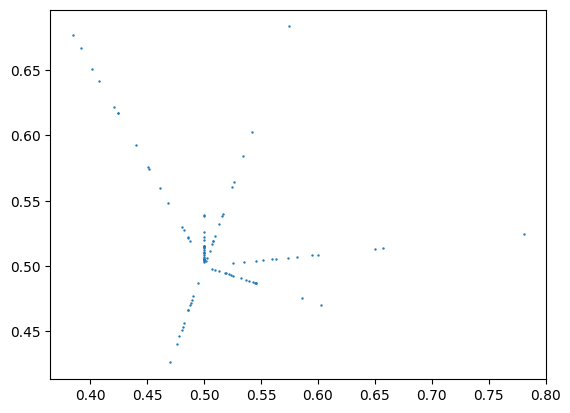

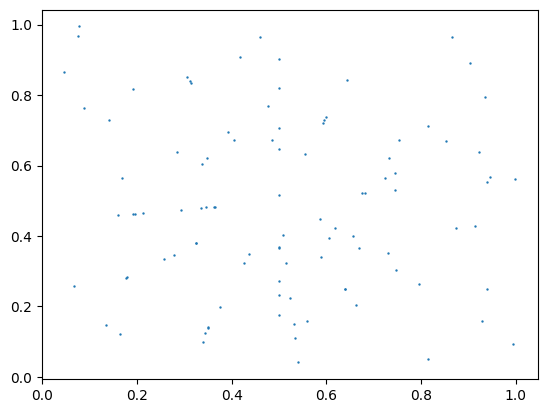

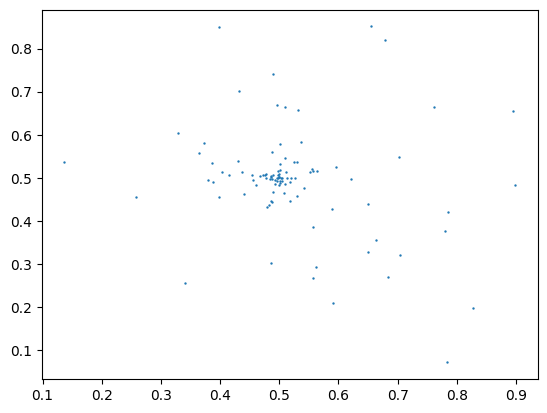

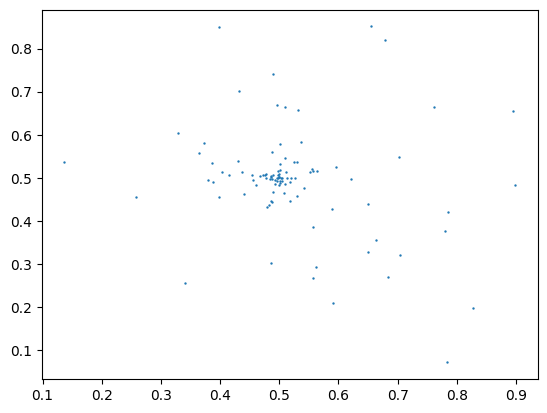

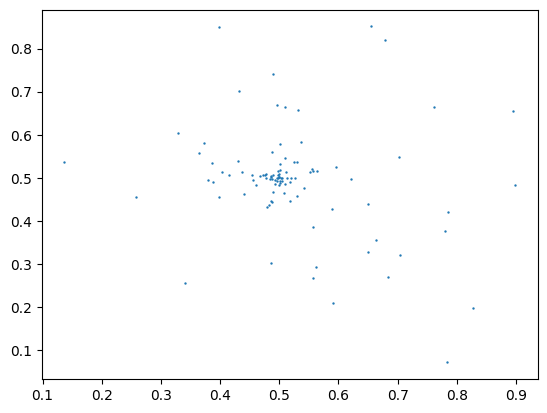

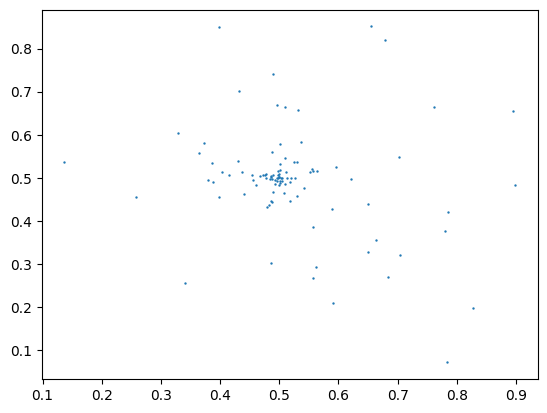

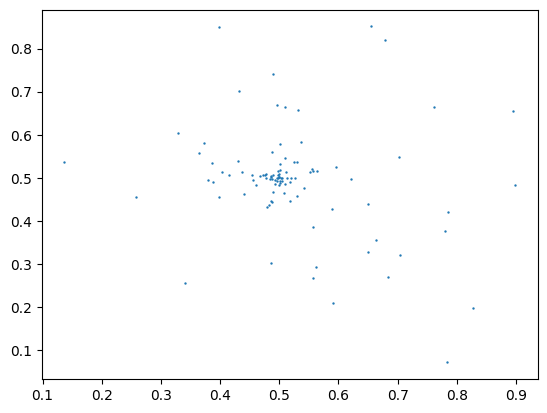

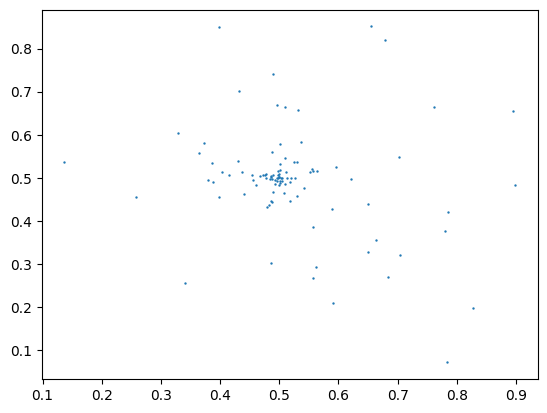

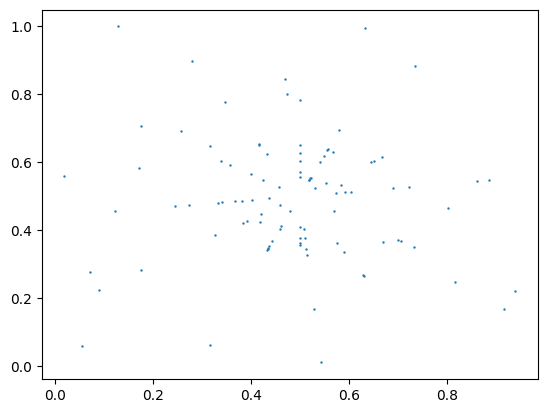

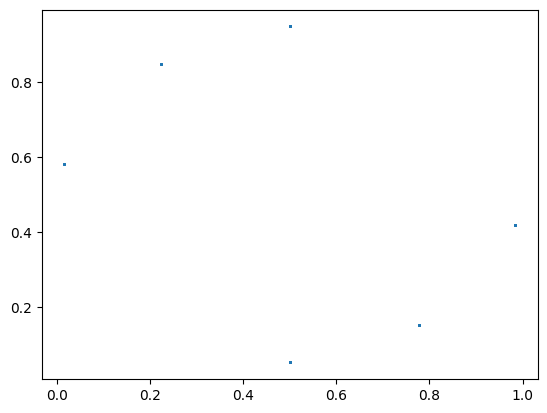

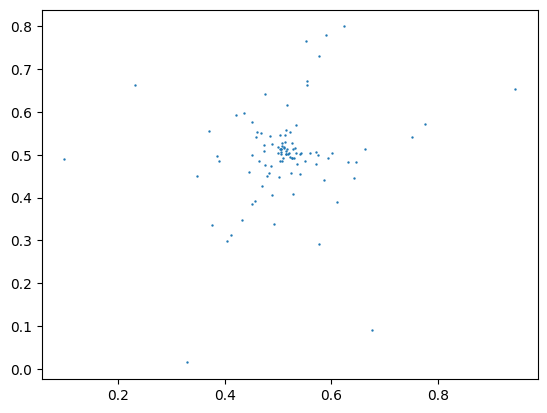

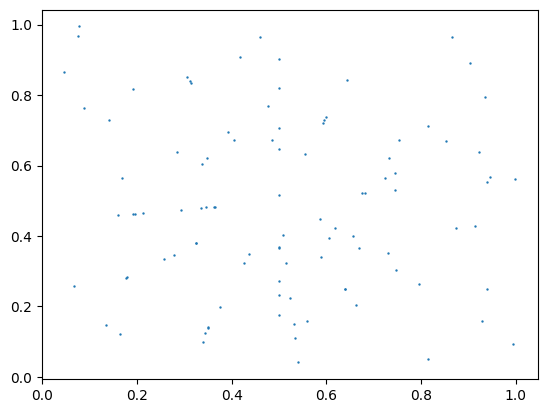

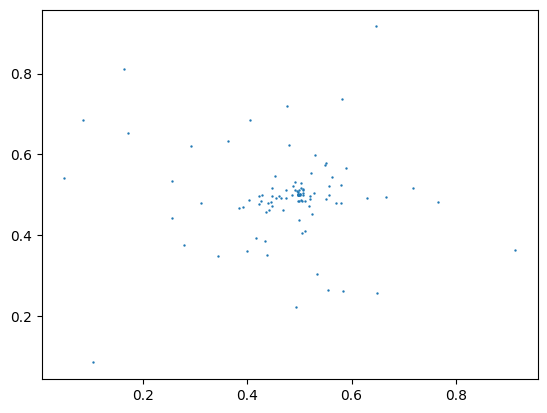

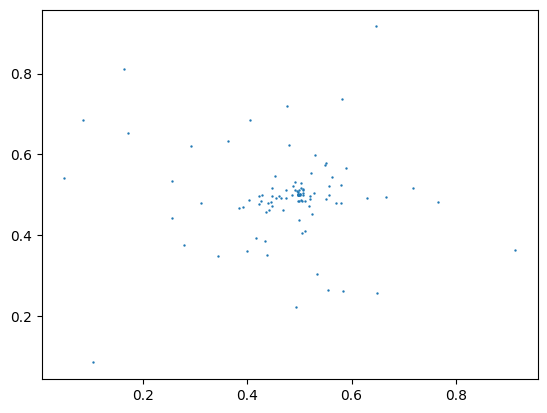

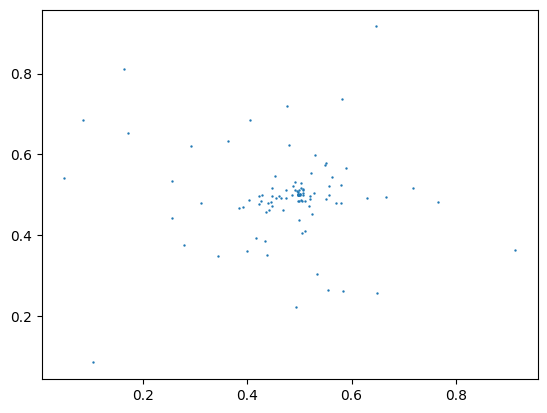

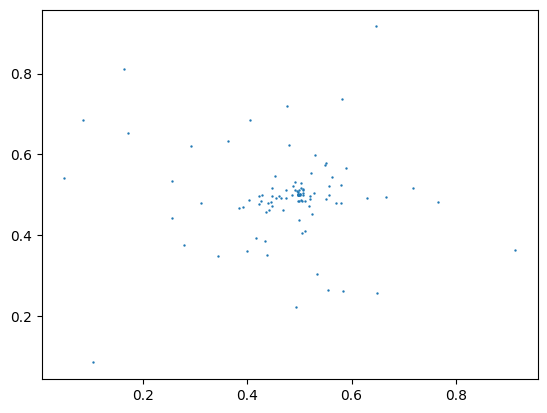

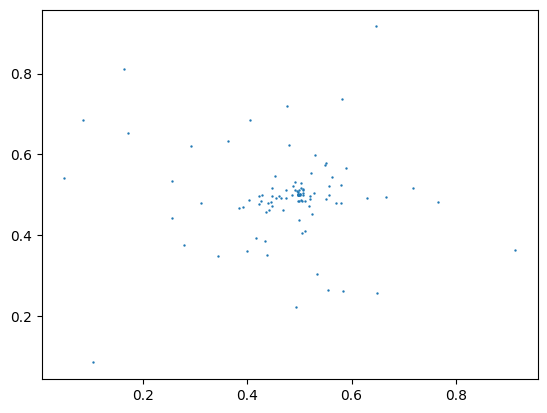

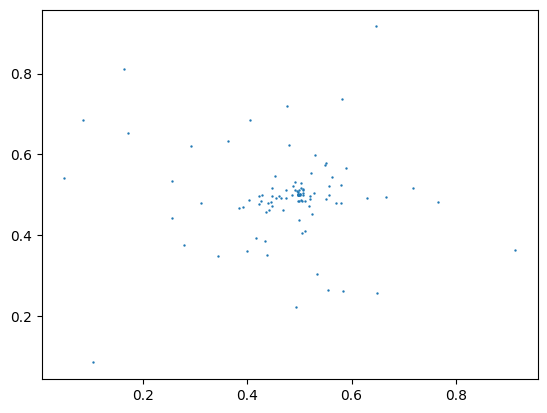

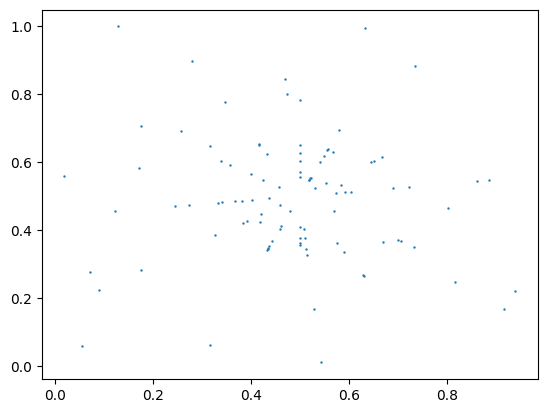

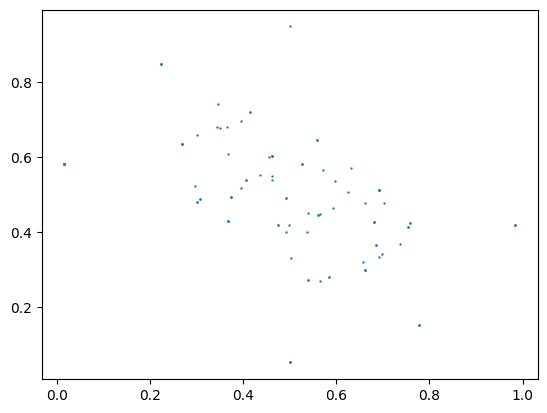

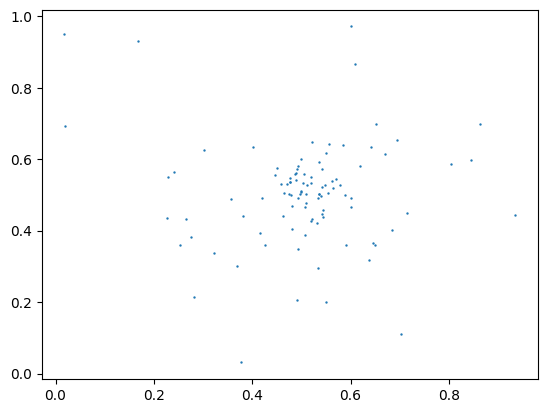

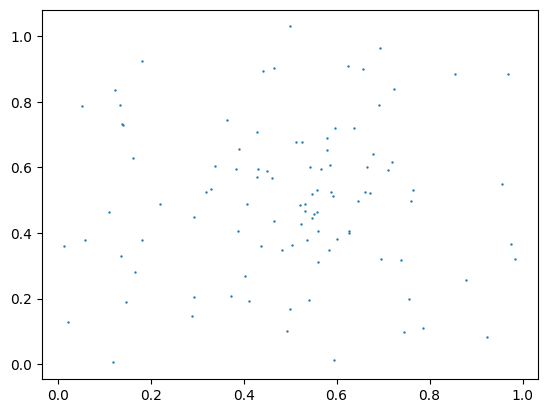

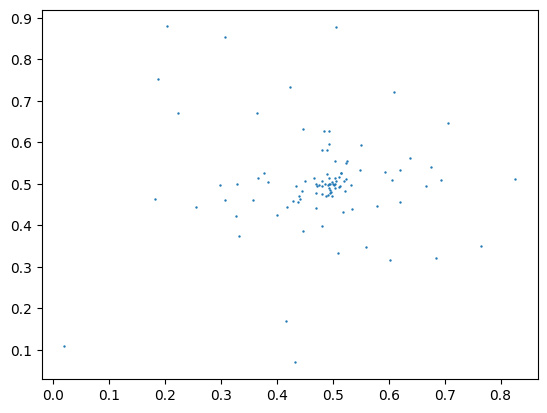

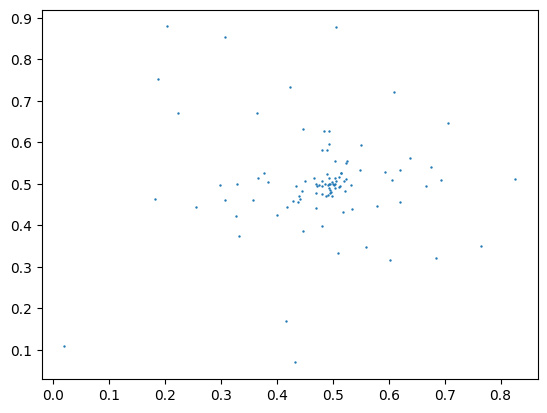

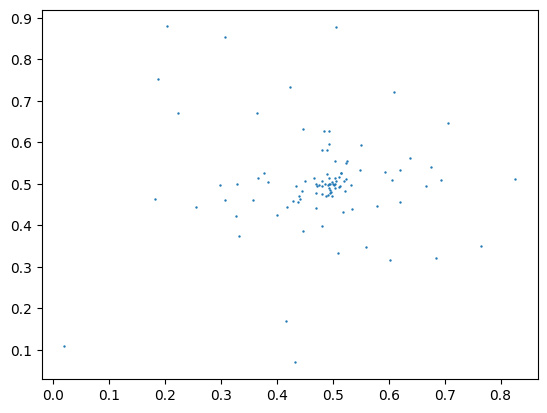

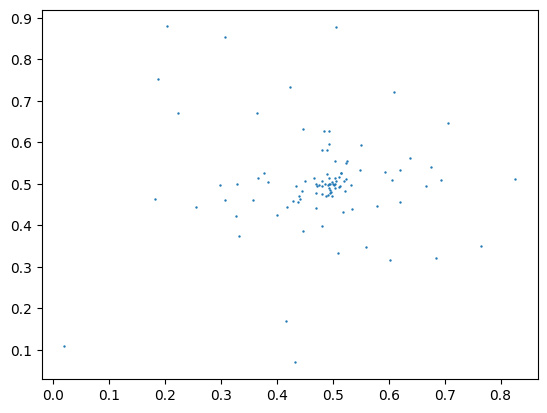

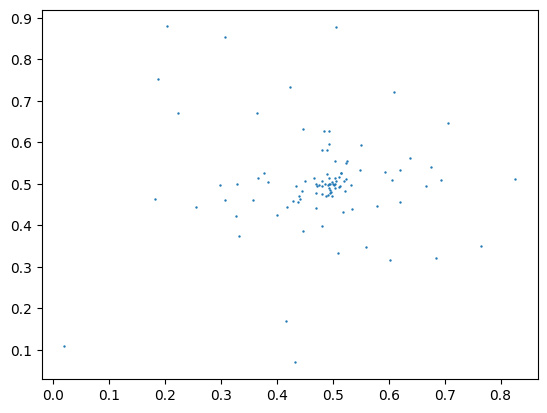

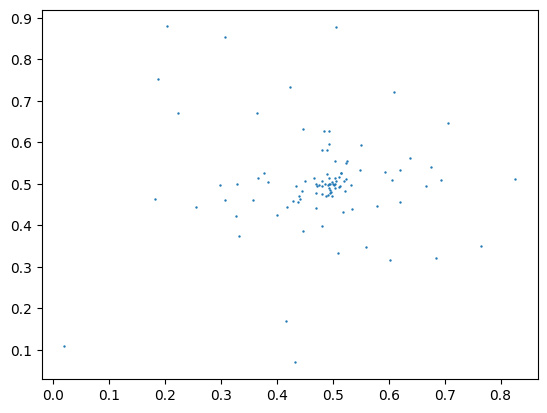

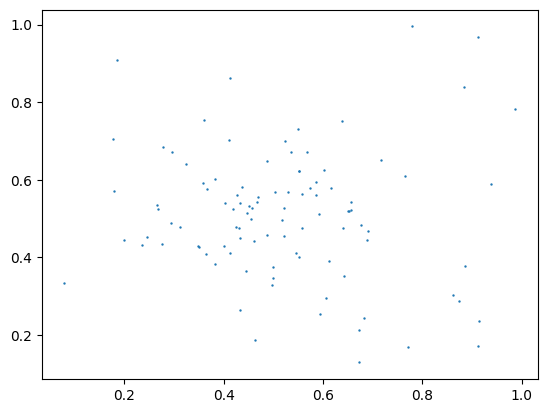

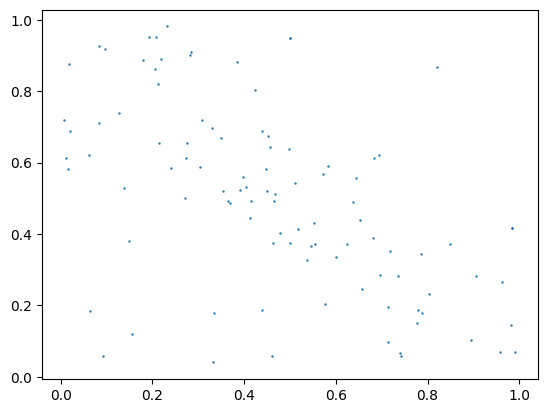

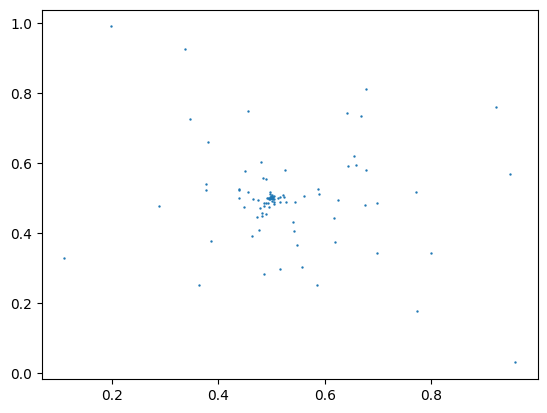

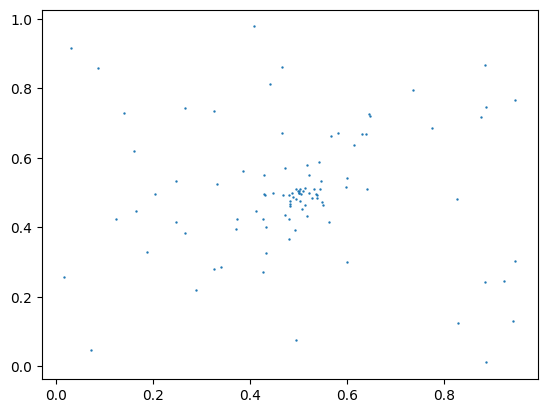

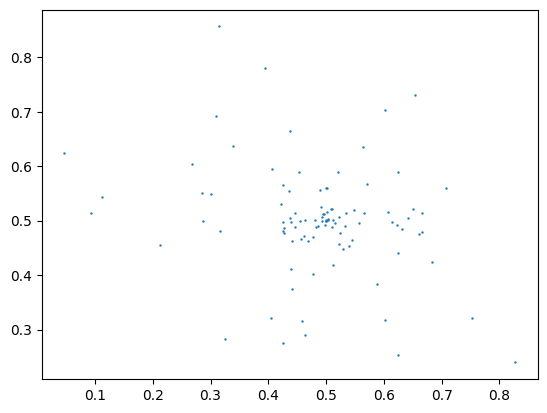

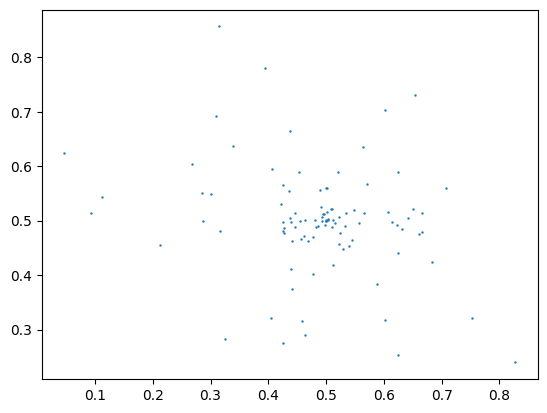

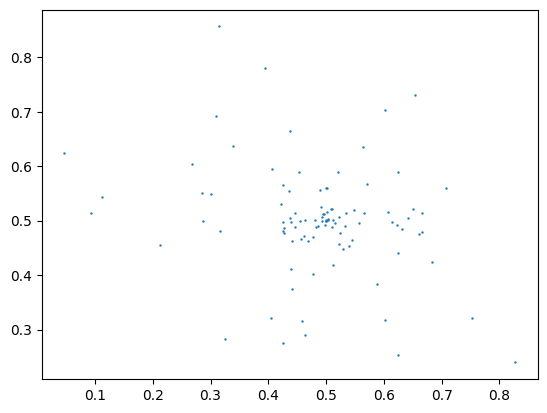

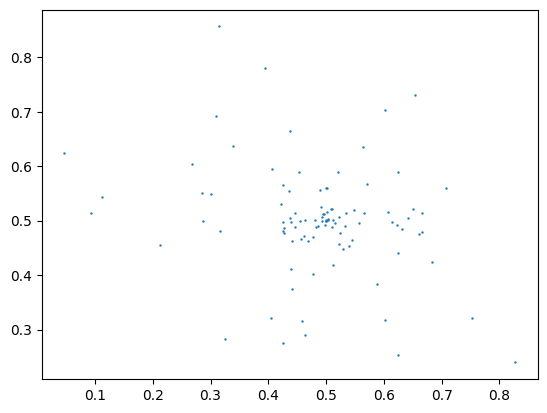

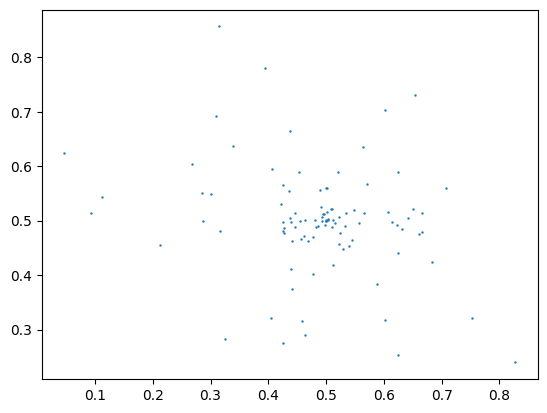

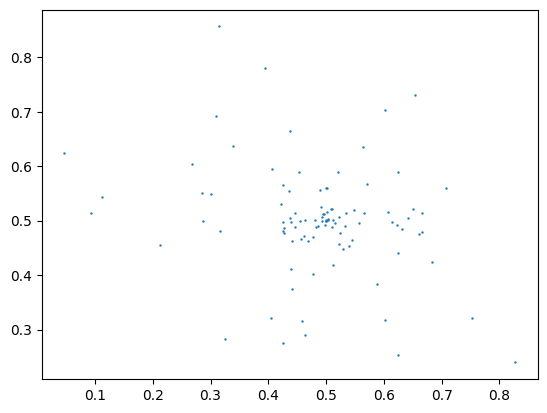

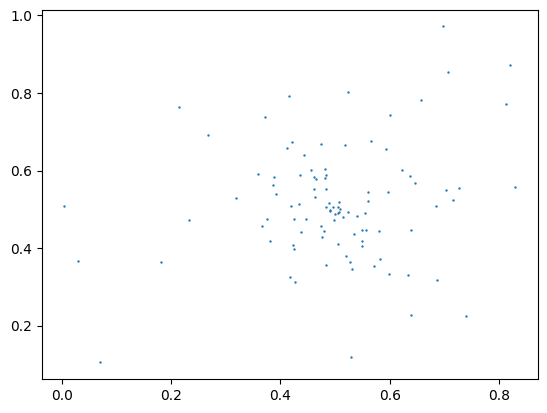

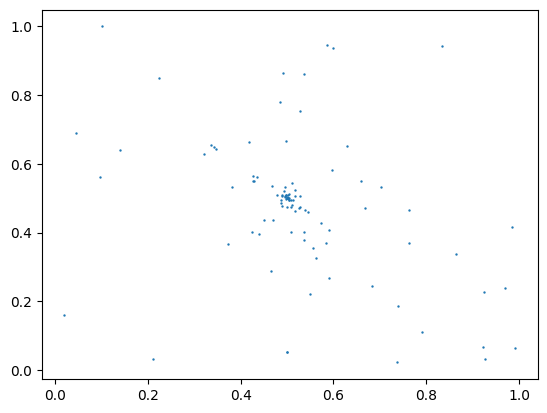

<Figure size 640x480 with 0 Axes>

In [8]:
import logging
import os
import sys
from functools import partial
from itertools import product
import numpy as np
import pandas as pd
import tqdm
from ConfigSpace import ConfigurationSpace, Configuration
import matplotlib.pyplot as plt

logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from config import bias_cmaes_explainer, cma_features_bias, cma_cs_bias
from iohxplainer.utils import runParallelFunction
import matplotlib.animation as animation




# data_file = "cma_bias_processed.pkl"
# df = pd.read_pickle(data_file)

# cmaes_explainer.load_results(data_file)
# use aucLarge for D30
bias_names = ["unif", "centre", "disc", "bounds", "clusters"]
df = pd.DataFrame(
    columns=[
        *cma_features_bias,
        *bias_names,
    ]
)

#let's explore the centre bias
bias[features] = bias[features].fillna("nan")
topconfs_with_centre_bias = bias.sort_values(by=['centre'], ascending=False).head(10).copy()

def check_bias(args):
    stderr = sys.stderr
    sys.stderr = open(os.devnull, "w")
    (
        config,
        alg_name,
    ) = args
    y, preds, samples = bias_cmaes_explainer.check_bias(
        config, 2, num_runs=100, method="deep", return_preds=True, file_prefix=None, return_samples=True
    )
    pred_mean = np.mean(np.array(preds), axis=0).flatten()
    return [pred_mean, samples]

configs = topconfs_with_centre_bias
config_list = []
for index, c in configs[features].iterrows():
    c["lambda_"] = "20"
    c["mu"] = "5"
    config_list.append(Configuration(cma_cs_bias, dict(c)))

for budget in [1,2,5,,10,100,1000]:
    bias_cmaes_explainer.budget = budget
    bias_cmaes_explainer.verbose = False
    i = 0
    alg_name="mod-cma-centre"

    partial_run = partial(check_bias)
    partial_run2 = partial(check_bias_polar)
    args = product(
        config_list,
        ["alg"],
    )
    res = runParallelFunction(partial_run, args)



    for i in range(len(config_list)):
        pred, samples = res[i][0], res[i][1]
        plt.scatter(samples[:,0],samples[:,1],s=0.5)
        plt.savefig(f"bias_results/dist2d_{i}_{budget}.png")
        plt.clf()
        c = dict(config_list[i])  # change to dict
        for p in range(len(pred)):
            c[bias_names[p]] = pred[p]

        df.loc[len(df)] = c
    df = pd.DataFrame(
        columns=[
            *cma_features_bias,
            *bias_names,
        ]
    )
    df.to_csv(
        f"cma-bias-top-centre-{budget}.csv",
        mode="w",
        header=True,
    )
